In [ ]:
from lib import masters_data_analytics_lib as mlib
from lib import stats as stats

import config_logging
import logging
import numpy as np
import pandas as pd
import pyodbc 
import urllib.request

log = logging.getLogger(__name__)
external_ip = urllib.request.urlopen('https://ident.me').read().decode('utf8')

In [ ]:
### Import ./.streamlit/secrets.toml

import toml
secrets = toml.load("./.streamlit/secrets.toml")

database_toml = secrets[secrets["database"]["flavour"]] 

database_props = {
                   "driver"   : database_toml["driver"]
                 , "host"     : database_toml["host"]
                 , "port"     : database_toml["port"]
                 , "instance" : database_toml["instance"]
                 , "database" : database_toml["database"]
                 , "username" : database_toml["username"]
                 , "password" : database_toml["password"]
}
db_conn = None
## Connect to the database -- this might move to a factory method to provide the connection


def get_db_conn(database_props):
    try:                      
        db_conn = pyodbc.connect(driver   = database_props["driver"]
                               , server   = "{},{}\{}".format(database_props["host"], database_props["port"], database_props["instance"])
                               , database = database_props["database"]
                               , uid      = database_props["username"]
                               , pwd      = database_props["password"])

        log.info(f"DATABASE CONNECTIVITY from {external_ip}") 
    except Exception as e:
        log.error(f"NO DATABASE CONNECTIVITY from {external_ip}") 
        log.error(e)
        raise Exception("DATABASE CONNECTIVITY")
        
    return db_conn


In [9]:
## City
city = "london"
search_term = "E1 6AN"

##
## LOAD ALL THE DATA FILES
##
## London Post Codes
sd_london_postcodes_file = "./data/streamlit_{}_postcodes_oa.csv".format(city)
sd_london_population_oa_file = "./data/streamlit_{}_population_oa.csv".format(city)
sd_london_household_oa_file = "./data/streamlit_{}_household_population_oa.csv".format(city)
sd_london_qualification_oa_file = "./data/streamlit_{}_qualifictation_population_oa.csv".format(city)

sd_london_population_oa_df   = mlib.csv_to_dataframe(sd_london_population_oa_file)
sd_london_postcodes_df = mlib.csv_to_dataframe(sd_london_postcodes_file)
sd_london_household_oa_df   = mlib.csv_to_dataframe(sd_london_household_oa_file)
sd_london_qualification_oa_df   = mlib.csv_to_dataframe(sd_london_qualification_oa_file) 


In [10]:
try:
    OAcode = sd_london_postcodes_df.loc[sd_london_postcodes_df["Post_Code"] == search_term]["OAcode"].values[0]
except:
    raise Exception("Unable to find post code {}".format(search_term))

other_post_codes = sd_london_postcodes_df.loc[sd_london_postcodes_df["OAcode"] == OAcode]["Post_Code"].to_numpy()
other_post_codes = np.delete(other_post_codes, np.where(other_post_codes == search_term))
number_of_boroughs = len(sd_london_postcodes_df["borough"].unique())


## Obtain the ward_name from the OACode
ward_name = sd_london_postcodes_df.loc[sd_london_postcodes_df["OAcode"] == OAcode]["WARD_NAME"].values[0]
borough   = sd_london_postcodes_df.loc[sd_london_postcodes_df['OAcode'] == OAcode]["borough"].values[0]

other_wards = sd_london_postcodes_df.loc[sd_london_postcodes_df["borough"] == borough]["WARD_NAME"]
other_wards = other_wards.unique()
other_wards = np.delete(other_wards, np.where(other_wards == borough))

post_code_search_longitude = sd_london_postcodes_df.loc[sd_london_postcodes_df["Post_Code"] == search_term]["longitude"].to_numpy()
post_code_search_latitude = sd_london_postcodes_df.loc[sd_london_postcodes_df["Post_Code"] == search_term]["latitude"].to_numpy()

pc_longitudes = sd_london_postcodes_df.loc[sd_london_postcodes_df["borough"] == borough]["longitude"].to_numpy()
pc_latitudes  = sd_london_postcodes_df.loc[sd_london_postcodes_df["borough"] == borough]["latitude"].to_numpy()


In [11]:
### Stats

###
### Population
###
pop_all_stats	  = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "All")
pop_male_stats	  = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "Males")
pop_female_stats  = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "Females")
pop_density_stats = stats.generate_stats(sd_london_population_oa_df, borough, ward_name, OAcode, "DensityPPH")


In [12]:
### Male female ratio
## OA
pop_male_female_oa_total =pop_male_stats["oacode_sum"] + pop_female_stats["oacode_sum"]
pop_male_oa_ratio = round(pop_male_stats["oacode_sum"]/pop_male_female_oa_total * 100,0)
pop_female_oa_ratio = round(pop_female_stats["oacode_sum"]/pop_male_female_oa_total * 100,0)
print("OA M:{} F:{}".format(pop_male_oa_ratio, pop_female_oa_ratio))

## Ward
pop_male_female_ward_total =pop_male_stats["ward_sum"] + pop_female_stats["ward_sum"]
pop_male_ward_ratio = round(pop_male_stats["ward_sum"]/pop_male_female_oa_total * 100,0)
pop_female_ward_ratio = round(pop_female_stats["ward_sum"]/pop_male_female_oa_total * 100,0)
print("Ward M:{} F:{}".format(pop_male_ward_ratio, pop_female_ward_ratio))

## Borough
pop_male_female_borough_total = pop_male_stats["borough_sum"] + pop_female_stats["borough_sum"]
pop_male_borough_ratio = round(pop_male_stats["borough_sum"]/pop_male_female_borough_total * 100,0)
pop_female_borough_ratio = round(pop_female_stats["borough_sum"]/pop_male_female_borough_total * 100,0)
print("Borough M:{} F:{}".format(pop_male_borough_ratio, pop_female_borough_ratio))

## Borough Average
pop_male_female_city_borough_total = pop_male_stats["city_sum"] + pop_female_stats["city_sum"]
pop_male_city_ratio = round(pop_male_stats["city_sum"]/pop_male_female_city_borough_total * 100,0)
pop_female_city_ratio = round(pop_female_stats["city_sum"]/pop_male_female_city_borough_total * 100,0)

print(pop_male_city_ratio)


OA M:64.0 F:36.0
Ward M:64.0 F:36.0
Borough M:55.0 F:45.0
49.0


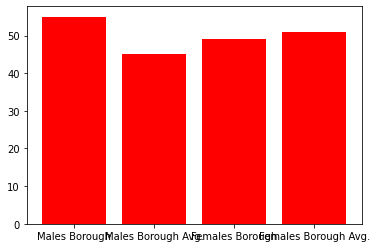

In [13]:
import matplotlib.pyplot as plt

# create data
x = ["Males Borough", "Males Borough Avg.", "Females Borough", "Females Borough Avg."]
y1 = [pop_male_borough_ratio, pop_female_borough_ratio, pop_male_city_ratio, pop_female_city_ratio]
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
# plt.bar(x, y2, bottom=y1, color='b')
plt.show()

In [14]:
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
import pylab
from itertools import product
import numpy as np


if 1==1:

    # pop_male_borough_ratio = 20
    # pop_male_city_ratio = 50
    # pop_female_borough_ratio = 80
    # pop_female_city_ratio = 50

    _data = [
                     pop_male_ward_ratio
                    , pop_male_borough_ratio
                    , pop_male_city_ratio
                    , pop_female_ward_ratio
                    , pop_female_borough_ratio
                    , pop_female_city_ratio]

    
    
    options = ["male", "female"]
    names = ["ward", "borough", "borough average"]
    title = "Gender Population - OA, Borough and Borough Average"
    props = lambda key: {'color': 'orange' if 'male' in key else 'deepskyblue'}
    

    matrix = list(product(names, options))

    index = pd.MultiIndex.from_tuples(matrix, names=names)
    
    print(index)

    data = pd.Series(_data, index=index)

    mosaic(data, gap=0.01, title='Who knows multiple foregin languages? - Mosaic Chart')

    pylab.show()    
    
    
    
    
#     mosaic(data, gap=0.01, title='Gender Population - OA, Ward, Borough and Borough Average', properties=props)


#     mlib.save_plot(plot=pylab, path="c:/temp/", name="x.png", save_artefacts=True)
#     pylab.show()


ValueError: Length of names must match number of levels in MultiIndex.

MultiIndex([(             'OA',   'male'),
            (             'OA', 'female'),
            (           'ward',   'male'),
            (           'ward', 'female'),
            (        'borough',   'male'),
            (        'borough', 'female'),
            ('borough average',   'male'),
            ('borough average', 'female')],
           names=['male', 'female'])


<module 'pylab' from 'C:\\DISTRIBUTIONS\\Python\\Python3_10_2\\lib\\site-packages\\pylab.py'>

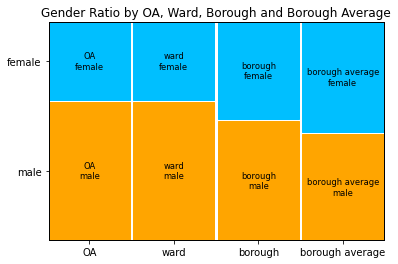

In [15]:
import pandas as pd
import pylab
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

# options == male/female || yes/no
# names   == oa->boroufh avg || male/femal

def mekko_chart(data, options, names, title, props):
    """
    Makes a mekko chart
    """
    ## Changing the order of this will change the axis
    matrix = list(product(names, options))
    index = pd.MultiIndex.from_tuples(matrix, names=options)
    print(index)
    
    data_series = pd.Series(data, index=index)
    mosaic(data_series, gap=[0.01, 0.01], title=title, properties=props)
    
    return pylab

### Call the method

data = [pop_male_oa_ratio
      , pop_female_oa_ratio
      , pop_male_ward_ratio
      , pop_female_ward_ratio
      , pop_male_borough_ratio
      , pop_female_borough_ratio
      , pop_male_city_ratio
      , pop_female_city_ratio
]

options = ["male", "female"]
names = ["OA", "ward", "borough", "borough average"]
title = "Gender Population - OA, Borough and Borough Average"
props = lambda key: {'color': 'orange' if 'male' in key else 'deepskyblue'}
title = "Gender Ratio by OA, Ward, Borough and Borough Average"

mekko_chart(data=data, options=options, names=names, title=title, props=props)


MultiIndex([(  'male', 'yes'),
            (  'male',  'no'),
            ('female', 'yes'),
            ('female',  'no')],
           names=['male', 'female'])


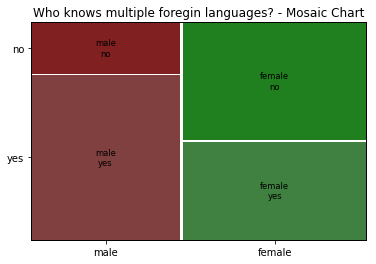

In [16]:
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
import pylab
from itertools import product
import numpy as np

rand = np.random.random

speaks_mul_foreign_languages = list(product(['male', 'female'], ['yes', 'no']))

index = pd.MultiIndex.from_tuples(speaks_mul_foreign_languages, names=['male', 'female'])

print(index)

data = pd.Series(rand(4), index=index)

mosaic(data, gap=0.01, title='Who knows multiple foregin languages? - Mosaic Chart')

pylab.show()

In [17]:
## Connect to database and retrive data from view


db_conn = get_db_conn()
sql = "SELECT * FROM income_london WHERE [Date] = ? ORDER BY [Date] DESC, [LAD] ASC, [MSOA] ASC"
# data = pd.read_sql(sql, db_conn)  # without parameters [non-prepared statement]

try:
    cursor = db_conn.execute(sql, ("2018"))
except pyodbc.Error as e:
    log.error(e)
    
log.debug(len(cursor.fetchall()))
    
db_conn.close()    


2022-07-24 12:34:31,373 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189
2022-07-24 12:34:31,975 [DEBUG] __main__: 983


In [76]:
## Income for a given post_code -> ward_name -> borough
##
## ward_name will give us the parent msoa so we can get the income for each year within that msoa

year_from = 2012
year_to   = 2018


db_conn = get_db_conn()

city_income_min_max_avg_sql ="""
SELECT [Date] 						                AS [Date]
      , ROUND(AVG([total_annual_income_net_gbp]),0) AS [city_total_annual_income_net_gbp_avg]
      , ROUND(MIN([total_annual_income_net_gbp]),0) AS [city_total_annual_income_net_gbp_min]
      , ROUND(MAX([total_annual_income_net_gbp]),0) AS [city_total_annual_income_net_gbp_max]
FROM income_uk_ons 		 INC
WHERE [MSOA] IN (SELECT DISTINCT [LPC].[MSOA] FROM IDX_LONDONPOSTCODES LPC)
AND   CONVERT(int, [Date]) BETWEEN {} AND {}
GROUP BY [Date]
ORDER BY [Date] ASC;
""".format(year_from, year_to)

city_min_max_avg_df = pd.read_sql_query(city_income_min_max_avg_sql, db_conn, index_col="Date")
# log.debug(city_min_max_avg_df.head())

if 1==1:
    ward_income_avg_sql = """
    SELECT [Date] 						                AS [Date]
          , ROUND(AVG([total_annual_income_net_gbp]),0) AS [ward_total_annual_income_net_gbp_avg]
    FROM income_uk_ons 		 INC
       , IDX_LONDONPOSTCODES LPC
    WHERE INC.[MSOA] = LPC.[MSOA]
    AND   INC.[LAD]  = LPC.[LAD]
    AND   LPC.[LAD_NAME] = '{}'
    AND   LPC.[WARD_NAME] = '{}'
    AND   CONVERT(int, [Date]) BETWEEN {} AND {}
    GROUP BY [Date];
    """.format("Merton", "Abbey", year_from, year_to)

    ward_avg_df = pd.read_sql_query(ward_income_avg_sql, db_conn, index_col="Date")
    # log.debug(ward_avg_df.head())

db_conn.close()

city_ward_min_max_avg_wide_df = pd.concat([city_min_max_avg_df, ward_avg_df], axis=1)
city_ward_min_max_avg_wide_df


2022-07-24 13:44:20,128 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,city_total_annual_income_net_gbp_avg,city_total_annual_income_net_gbp_min,city_total_annual_income_net_gbp_max,ward_total_annual_income_net_gbp_avg
Date,,,,
2012,46489.0,28600.0,89960.0,63956.0
2014,49004.0,28600.0,88920.0,65955.0
2016,36307.0,25500.0,66200.0,42363.0
2018,43114.0,30800.0,63700.0,54569.0


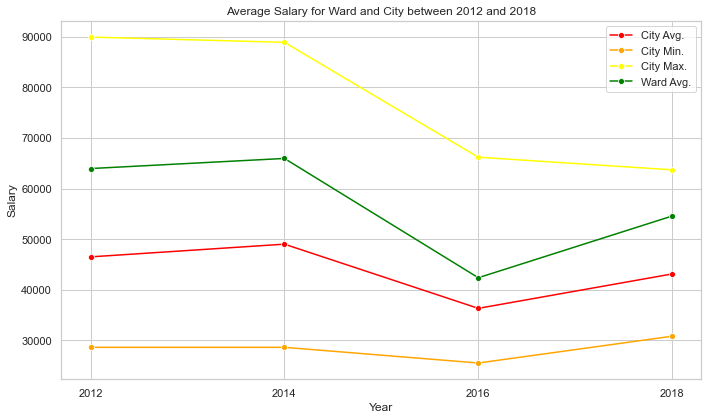

In [81]:
## Make a copy
city_ward_min_max_avg_long_df = city_ward_min_max_avg_wide_df.copy()

## Copy the index to a "Year" Column
city_ward_min_max_avg_long_df["Year"] = city_ward_min_max_avg_long_df.index

## Change to Long from Wide data frame to use in the plot
# city_ward_min_max_avg_long_df = city_ward_min_max_avg_long_df.melt("Year", var_name="cols", value_name="salary")
city_ward_min_max_avg_long_df

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

x_fig_size = 10
y_fig_size = 6

## Set the size
sns.set(rc={"figure.figsize":(x_fig_size, y_fig_size)})

## Set the theme
sns.set_style("whitegrid")

# plot = sns.catplot(data=city_ward_min_max_avg_long_df, x="Year", y="salary", hue="cols", kind="point", legend=False, height=y_fig_size, aspect=x_fig_size/y_fig_size)

fig, ax = plt.subplots()
sns.lineplot(data=city_ward_min_max_avg_long_df, x="Year", y="city_total_annual_income_net_gbp_avg", ax=ax, label='City Avg.', color='red', marker='o')
sns.lineplot(data=city_ward_min_max_avg_long_df,x="Year", y="city_total_annual_income_net_gbp_min", ax=ax, label='City Min.', color='orange', marker='o')
sns.lineplot(data=city_ward_min_max_avg_long_df,x="Year", y="city_total_annual_income_net_gbp_max", ax=ax, label='City Max.', color='yellow', marker='o')
sns.lineplot(data=city_ward_min_max_avg_long_df,x="Year", y="ward_total_annual_income_net_gbp_avg", ax=ax, label='Ward Avg.', color='green', marker='o')

ax.set_title("Average Salary for Ward and City between {} and {}".format(year_from, year_to))
ax.set_ylabel("Salary")
ax.legend(title="legend")
ax.legend(loc="upper right")
plt.tight_layout()

# g

# sns.lineplot(data = city_ward_min_max_avg_df, x="index", 

In [84]:
def merge_two_dicts(x, y):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

dict_validated = {"Field_1":2}
dict_no_validation = {"Field_1":1, "year_from":2012}

dict_validated = merge_two_dicts(dict_no_validation, dict_validated)
              
log.debug(dict_validated)
                                 


2022-07-24 14:45:24,231 [DEBUG] __main__: {'Field_1': 2, 'year_from': 2012}
